## Importing the Packages

In [16]:
!pip install pmdarima -U
!pip install arch -U
!pip install yfinance -U

Requirement already up-to-date: pmdarima in /opt/conda/lib/python3.7/site-packages (1.6.0)
Requirement already up-to-date: arch in /opt/conda/lib/python3.7/site-packages (4.14)
Requirement already up-to-date: yfinance in /opt/conda/lib/python3.7/site-packages (0.1.54)


In [17]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [18]:
raw_data = yfinance.download(tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = "ticker", auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [19]:
df = raw_data.copy()

## Defining Key Dates

In [20]:
# Starting Date
start_date = '2009-04-05'

# First Official Announcement (On this day VW announced they owned 49.9% of Porche)
ann_1 = '2009-12-09'

# Second Official Announcement(On this day VW announced Full Ownership of Porche at 50.01% )
ann_2 = '2012-07-05'

# Ending Date
end_date = '2014-01-01'

# Dieselgate Scandal
d_gate = '2015-09-20'

## Preprocessing the Data

In [21]:
# Extracting closing prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume (Number of Purchases and Sales each day)
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume


### Assigning Frequency and Filling N/A Values

In [22]:
df = df.asfreq('b')
df = df.fillna(method = 'bfill')

### Removing Surplus Data

In [23]:
df = df.drop(['VOW3.DE','PAH3.DE', 'BMW.DE'], axis = 1)

#### Since we're examining a specific event in time rather than examining the future, we do not need to Split the Dataset onto a  training and testing set

## Plotting the Prices
### This is done to see how the three time series move over time

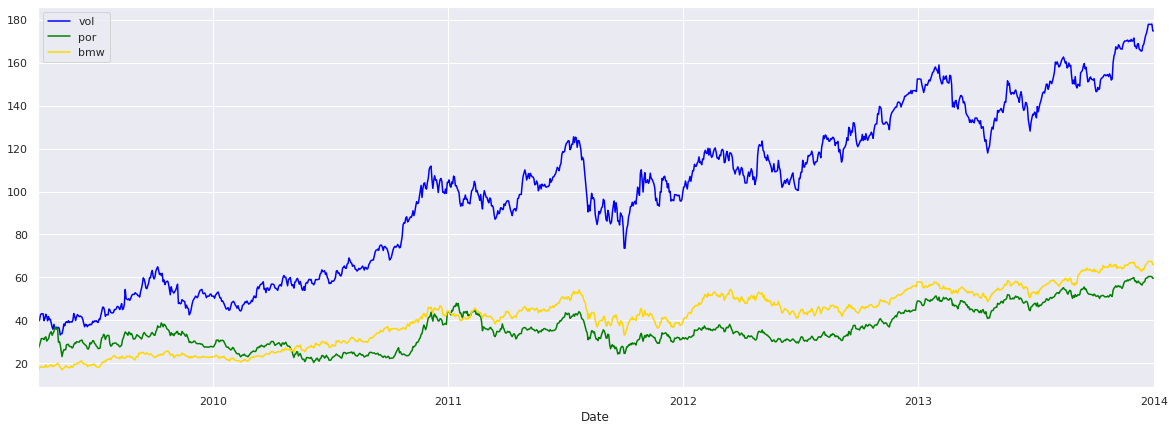

In [24]:
df.vol[start_date:end_date].plot(figsize = (20,7), color = 'blue')
df.por[start_date:end_date].plot(color = 'green')
df.bmw[start_date:end_date].plot(color = 'gold')
plt.legend()
plt.show()

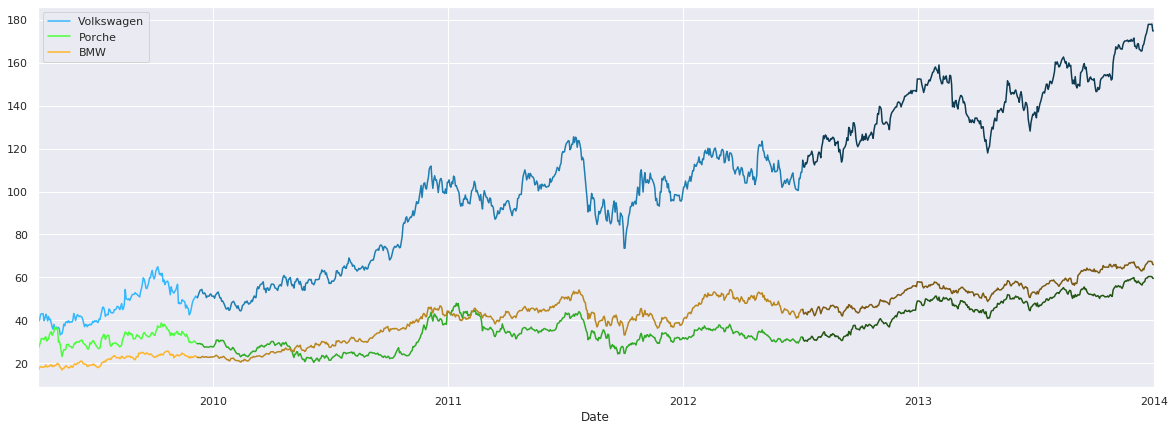

In [25]:
df.vol[start_date:ann_1].plot(figsize = (20,7), color = '#33B8FF')
df.por[start_date:ann_1].plot(color = '#49FF3A')
df.bmw[start_date:ann_1].plot(color = '#FEB628')

df.vol[ann_1:ann_2].plot(color = '#1E7EB2')
df.por[ann_1:ann_2].plot(color = '#2FAB25')
df.bmw[ann_1:ann_2].plot(color = '#BA861F')

df.vol[ann_2:end_date].plot(color = '#0E3A52')
df.por[ann_2:end_date].plot(color = '#225414')
df.bmw[ann_2:end_date].plot(color = '#7C5913')

plt.legend(['Volkswagen', 'Porche', 'BMW'])
plt.show()

### From the above Graph
1. **Prior to the first annoincement, the stocks of VW and Porche move in a similar fashion. However, VW's numbers seem to be almost twice as high. Afterwards, the gap between the two seems to grow bigger with time**
2. **If we look at BMW's numbers, they resemble the Porche ones closer than the VW ones(at a glance)**
3. **To get an idea of how similar each one of these series is similar to the others we will be examining their Correlation.** 

## Correlation

In [26]:
print('Correlation between the companies from ' + str(start_date) + ' to ' + str(end_date) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation between the companies from 2009-04-05 to 2014-01-01

Volkswagen and Porche Correlation : 	0.8348049992443258
Volkswagen and BMW Correlation : 	0.9799384511501867
Porche and BMW Correlation : 		0.8039398481425047


### Change in correlation from April 5,2009 to December 9, 2009 when the First announcement of Volkswagen holding 49% of Porche's shares was made

In [27]:
print('Correlation between the companies from ' + str(start_date) + ' to ' + str(ann_1) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation between the companies from 2009-04-05 to 2009-12-09

Volkswagen and Porche Correlation : 	0.6633400188255092
Volkswagen and BMW Correlation : 	0.8428353250592515
Porche and BMW Correlation : 		0.6095045440130231


### Change in correlation from December 9,2009 to July 5, 2012 when the Second announcement of Volkswagen holding 50.01% of Porche's shares(Full ownership) was made

In [28]:
print('Correlation between the companies from ' + str(ann_1) + ' to ' + str(ann_2) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation between the companies from 2009-12-09 to 2012-07-05

Volkswagen and Porche Correlation : 	0.742211441681872
Volkswagen and BMW Correlation : 	0.9795942983809952
Porche and BMW Correlation : 		0.7035985466970395


### Change in correlation from July 5, 2012 to January 1, 2014 when Volkswagen Completely Buys Out Porche

In [29]:
print('Correlation between the companies from ' + str(ann_2) + ' to ' + str(end_date) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation between the companies from 2012-07-05 to 2014-01-01

Volkswagen and Porche Correlation : 	0.9405236820664735
Volkswagen and BMW Correlation : 	0.9284447102983764
Porche and BMW Correlation : 		0.9494111676682194


#### After the complete buyout of Porche by Volksvagen, we obseve a Higher Correlation between the prices of VW and Porche i.e. they are essentially moving as ONE entity showing that the prices of one directly affect the other

In [30]:
print('Correlation between the companies from ' + str(end_date) + ' to ' + str(df.index[-1]) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation between the companies from 2014-01-01 to 2020-04-30 00:00:00

Volkswagen and Porche Correlation : 	0.9466838471666116
Volkswagen and BMW Correlation : 	0.528579667482827
Porche and BMW Correlation : 		0.49899396848078165


#### From the Correlation stats above we can see that although VW and Porsche still seem to be highly correlated/dependent, it is not the case with the latter, this my be because of the Dieselgate Scandal

In [32]:
print('Correlation between the companies in the Dieselgate Scandle from ' + str(end_date) + ' to ' + str(d_gate) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][end_date:d_gate].corr(df['por'][end_date:d_gate])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][end_date:d_gate].corr(df['bmw'][end_date:d_gate])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][end_date:d_gate].corr(df['bmw'][end_date:d_gate])))

Correlation between the companies in the Dieselgate Scandle from 2014-01-01 to 2015-09-20

Volkswagen and Porche Correlation : 	0.9421376139206381
Volkswagen and BMW Correlation : 	0.8912207964688825
Porche and BMW Correlation : 		0.804587162136115


#### Hence, the Dieselgate scandal affected the correlations between the 3 stock prices at large

## Best Fitting Models

## For Volkswagen
### Examining how the VW trends change after the two Announcements

In [34]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1], m= 5, max_p = 5, max_q = 5)

mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2], m= 5, max_p = 5, max_q = 5)

mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date], m= 5, max_p = 5, max_q = 5)

In [35]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -329.605
Date:                Sat, 02 May 2020   AIC                            669.210
Time:                        12:21:18   BIC                            685.119
Sample:                    04-06-2009   HQIC                           675.661
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7502      0.464      1.618      0.106      -0.159       1.659
por            0.3859      0.093      4.169      0.000       0.205       0.567
bmw            0.6494      0.308      2.108      0.035       0.045       1.253
ar.L1          0.9634      0.020     48.675      0.000       0.925       1.002
sigma2         2.3414      0.159     14.718      0.000       2.030       2.653
===================================================================================
Ljung-Box (Q):                       38.25   Jarque-Bera (JB):               166.09
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -1095.725
Date:                           Sat, 02 May 2020   AIC                           2207.450
Time:                                   12:23:13   BIC                           2243.520
Sample:                               12-09-2009   HQIC                          2221.420
                                    - 07-05-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      3.490      0.000       0.002       0.006
por            0.7633      0.060     12.828      0.000       0.647       0.880
bmw            1.4605      0.069     21.311      0.000       1.326       1.595
ar.L1          0.9440      0.015     62.654      0.000       0.914       0.974
ma.L1         -0.9995      0.061    -16.427      0.000      -1.119      -0.880
ar.S.L5       -0.9928      0.059    -16.712      0.000      -1.109      -0.876
ma.S.L5        0.9883      0.072     13.680      0.000       0.847       1.130
sigma2         1.5296      0.124     12.349      0.000       1.287       1.772
===================================================================================
Ljung-Box (Q):                       25.72   Jarque-Bera (JB):                90.02
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -622.244
Date:                Sat, 02 May 2020   AIC                           1250.488
Time:                        12:23:24   BIC                           1262.378
Sample:                    07-05-2012   HQIC                          1255.202
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.6623      0.055     30.369      0.000       1.555       1.770
bmw            0.8046      0.086      9.381      0.000       0.637       0.973
sigma2         1.4352      0.070     20.461      0.000       1.298       1.573
===================================================================================
Ljung-Box (Q):                       28.08   Jarque-Bera (JB):               103.80
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Here, we see that after VW acqires Porche, the price of porche is greately increased because they are now a single entity. Hence, the Price of Porche today will be a more accurate estimator for the prices in the future as compared to the price of Volkswagen yesterday. 
### ** i.e. New information seems to have a higher impact on trends as compared to past patterns **

## For Porsche
### Here, we will summarize similar models for each period of Porsche prices and see if the trend persists

In [38]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1], m= 5, max_p = 5, max_q = 5)

mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2], m= 5, max_p = 5, max_q = 5)

mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date], m= 5, max_p = 5, max_q = 5)

In [40]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -238.779
Date:                Sat, 02 May 2020   AIC                            489.558
Time:                        12:43:46   BIC                            508.649
Sample:                    04-06-2009   HQIC                           497.300
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6190      0.404      1.533      0.125      -0.173       1.411
vol            0.1192      0.055      2.157      0.031       0.011       0.227
bmw            0.8576      0.154      5.557      0.000       0.555       1.160
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.8468      0.060     14.098      0.000       0.729       0.964
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -629.007
Date:                Sat, 02 May 2020   AIC                           1268.013
Time:                        12:44:22   BIC                           1290.557
Sample:                    12-09-2009   HQIC                          1276.745
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0226      0.024     -0.938      0.348      -0.070       0.025
vol            0.1867      0.017     11.219      0.000       0.154       0.219
bmw            0.3148      0.045      7.022      0.000       0.227       0.403
ar.L1          0.0712      0.030      2.343      0.019       0.012       0.131
sigma2         0.3817      0.012     32.515      0.000       0.359       0.405
===================================================================================
Ljung-Box (Q):                       35.66   Jarque-Bera (JB):              1072.22
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  390
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 5)   Log Likelihood                -236.012
Date:                           Sat, 02 May 2020   AIC                            484.023
Time:                                   12:44:51   BIC                            507.805
Sample:                               07-05-2012   HQIC                           493.451
                                    - 01-01-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0228      0.020      1.162      0.245      -0.016       0.061
vol            0.2302      0.014     16.410      0.000       0.203       0.258
bmw            0.2407      0.041      5.857      0.000       0.160       0.321
ma.L1         -0.0762      0.056     -1.373      0.170      -0.185       0.033
ma.S.L5       -0.1355      0.058     -2.337      0.019      -0.249      -0.022
sigma2         0.1970      0.008     25.906      0.000       0.182       0.212
===================================================================================
Ljung-Box (Q):                       33.69   Jarque-Bera (JB):               612.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### According to the model of the sumary after the acquisition, we see that the best fit model is a Seasonal model - SARIMAX(0,1,1)(0,0,1,5). This shows us that trends are affected by current events rather than pre-existing patterns

## Predictions for the Future

## For Folkswagen

In [46]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], 
                                exogenous = df[['por','bmw']][start_date:ann_1],
                                m = 5,
                                max_p= 5,
                                max_q = 5,
                                max_P = 5,
                                max_Q = 5,
                                trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por', 'bmw']][ann_1:ann_2]),index=df[ann_1:ann_2].index)

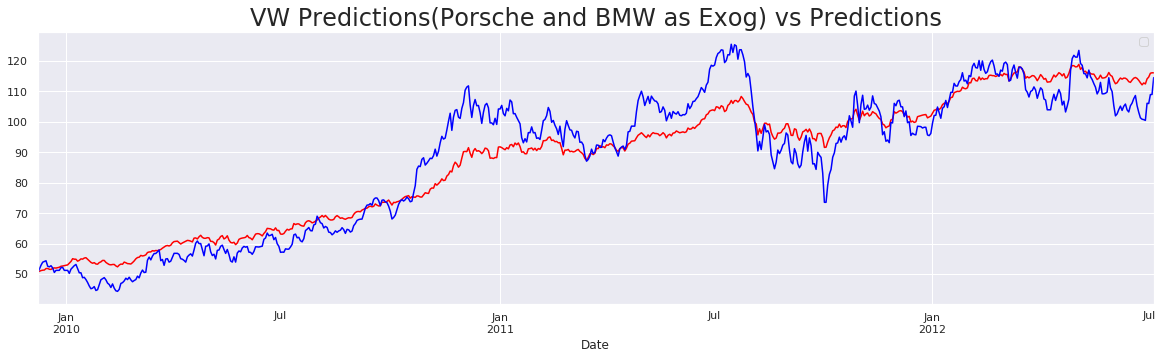

In [48]:
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red" )
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions(Porsche and BMW as Exog) vs Predictions", size = 24)
plt.legend(['Predictions'], ['Actuals'])
plt.show()

### From the above forecast we see that the trends are lining up with the general trend, furthermore the model seems to be more conservative in forecasting sudden increases and decreases in the stock prices.

## Volatility

### Volitility of VW for Each Period

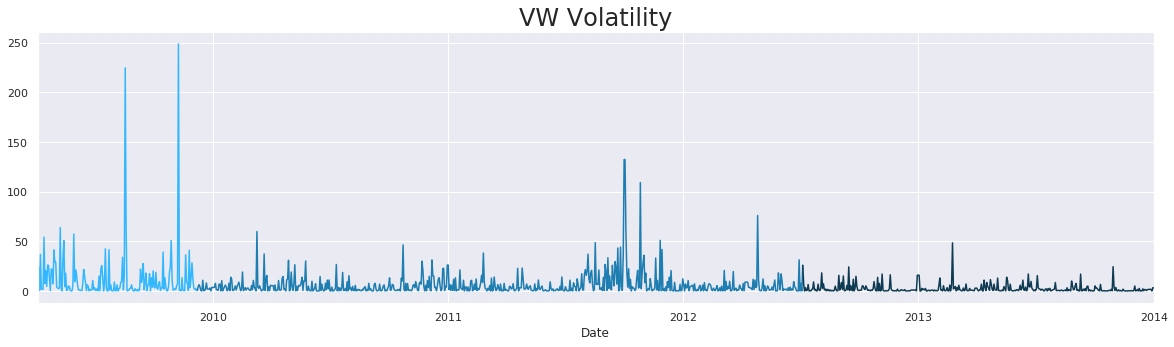

In [54]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = '#33B8FF' )
df['sq_vol'][ann_1:ann_2].plot(color = '#1E7EB2')
df['sq_vol'][ann_2:end_date].plot(color = '#0E3A52')
plt.title("VW Volatility", size = 24)
plt.show()

1. We see that VW has the highest volatility before any of the announcements
2. Notably, the stock becomes stable following each of the two announcements while, it showcases instability up to the time leading to each purchase

## Volatility Trends for Each Period

In [64]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2],  mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date],  mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 475.8106472182344
Iteration:     10,   Func. Count:     65,   Neg. LLF: 475.03031772801364
Iteration:     15,   Func. Count:     95,   Neg. LLF: 474.9915210237318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 474.9915209714288
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1526.9228402592855
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1526.7316954368202
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1526.731695435576
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     38,   Neg. LLF: 724.56203649128
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 724.5578157322791
            Iterations: 7
            

In [65]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.992
Distribution:                  Normal   AIC:                           957.983
Method:            Maximum Likelihood   BIC:                           970.710
                                        No. Observations:                  178
Date:                Sat, May 02 2020   Df Residuals:                      174
Time:                        13:38:01   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1571      0.266      0.590      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6195      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.197e-02      1.675  9.401e-02 [-2.624e-02,  0.334]
beta[1]        0.0000      0.349      0.000      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

### Here, we see a ß(beta) value ≈ 1 this shows that the trends and variance aren't as persistent as we would expect

In [68]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Sat, May 02 2020   Df Residuals:                      668
Time:                        13:38:01   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

#### Here, we observe that ß≈0; this means that the autocorrelation in the conditional variance is significant. Furthermore, the significant constant 'mu' indicates that theres is some constatnt trend in the 'Returns' values. Additionally, the value of omega shows that the exact same feature as Returns can be found in the volatility as well.

#### Hence, we never expect returns or their volatility to ever be perfectly stable(which is normal for markets lacking efficiency)

In [69]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Sat, May 02 2020   Df Residuals:                      386
Time:                        13:38:01   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""

#### Here, we observe  non-significant values for alpha and omega which suggests that there is some autocorrelation in volatility which fits the Volatility Clustering Feature

# Overall, the purchase of Porche has provided Volkswagen with a larger share of the market. This in return, has resulted in much lower volatility after each announcement making VW stocks a more appealing prospect.